# Tractography pipeline for neuronal fibers
This notebook take a 3d volume of images and returns the detected axons

## Importing dependencies

In [1]:
from bossHandler import bossHandler
from tractography import vertices
from intern.resource.boss.resource import *
from intern.remote.boss import BossRemote
from skimage import filters
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.mlab as mlab
import glob
import skfmm
from scipy.ndimage.filters import laplace
from skimage.morphology import binary_opening, binary_closing, binary_dilation
from skimage.morphology import skeletonize_3d,label
from scipy.ndimage.morphology import *
from tifffile import imsave
from skimage import img_as_ubyte, img_as_uint, color
from tractools import run_tractography
from sklearn.cluster import KMeans

/usr/local/lib/python2.7/dist-packages/tifffile/tifffile.py:306: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "


## Download data from Boss
The bossHandler class uses Intern to connect to Boss and download volumes. If the tiff files are already downloaded (using ndpull), use the following cell to load from disk

In [2]:
# Parameters:
coll_name = 'ailey-dev'
exp_name = 'DRN-BLA_2378'
chan_name = 'Ch0'
x_rng = [9250, 9750]
y_rng = [18000, 18500]
z_rng = [500, 600]
test_lbl = '4'

# Using bossHandler class to download from Boss:
bHandler = bossHandler(coll_name)
bHandler.select_experiment(exp_name)
exp = bHandler.get_experiment()
bHandler.list_channels()
bHandler.select_channel(chan_name)
coor = bHandler.get_coordinate_frame()
data_cutout_raw = bHandler.get_cutout(x_rng, y_rng, z_rng)
data_cutout_raw = np.transpose(img_as_uint(data_cutout_raw),(1,2,0))

## Or, load input data from disk
The data can be loaded from a tiff stack on disk. The saved tiffs are output of the ndpull package saved to tifPath. If data is already loaded using the top cell, this step is not necessary.

In [ ]:
# # x_range = [9750, 10250]
# # y_range = [18000, 18500]
# # z_range = [500, 600]
# tifPath = '/run/mount/DRN-BLA_2378_2p_glycerol_Ch0/test_0/*.tif'
# tifList = sorted(glob.glob(tifPath))
# if tifList: # check if not empty
#     im_slice = plt.imread(tifList[0])
#     data_cutout_raw = im_slice
        
#     if len(tifList)>1: # check if more than 1 file
#         for tifFile in tifList[1:]:
#             im_slice = plt.imread(tifFile)
#             data_cutout_raw = np.dstack((data_cutout_raw, im_slice))

Visualize:

In [ ]:
plt.imshow(data_cutout_raw[:,:,50])

### Binarization using 4-means

In [ ]:
k = 4
data_cutout_binarized = np.copy(data_cutout_raw)
vol_size = data_cutout_raw.shape
for i in np.arange(0 , vol_size[2]):
    data_slice = data_cutout_binarized[:,:,i]
    kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1, precompute_distances= True, algorithm= 'auto').fit(data_slice.reshape(-1,1))
    cluster_labels = kmeans.predict(data_slice.reshape(-1,1))
    cluster_labels = cluster_labels.reshape(data_slice.shape)
#     c_id = np.argmax(kmeans.cluster_centers_)
    c_ids = np.argsort(kmeans.cluster_centers_, axis=0)    
    data_slice[cluster_labels == c_ids[-2]] = 1
    data_slice[cluster_labels != c_ids[-2]] = 0
    data_cutout_binarized[:,:,i] = data_slice
    
    

In [ ]:
c_ids = np.argsort(kmeans.cluster_centers_, axis=0)
print(c_ids)
print(kmeans.cluster_centers_)
print(c_ids[-2])

In [ ]:
cluster_labels.shape

## Binarization
Binarization is performed slice by slice using 4 component GMM. The cluster with the highest mean is picked as the binarized point set.

### slice-by-slice without subsampling 

In [82]:
gmm_nc = 4
data_cutout_binarized = np.copy(data_cutout_raw)
vol_size = data_cutout_raw.shape
for i in np.arange(0 , vol_size[2]):
    data_slice = data_cutout_binarized[:,:,i]
    uniq = np.unique(data_slice , return_counts=True)
    
    gmm = GaussianMixture(gmm_nc, covariance_type = 'diag').fit(data_slice.reshape(-1,1))
    cluster_labels = gmm.predict(data_slice.reshape(-1,1))
    cluster_labels = cluster_labels.reshape(data_slice.shape)
    x = np.arange(0,uniq[1].shape[0])
    c_id = np.argmax(gmm.means_) # index of the cluster with highest mean
    
    data_slice[cluster_labels == c_id] = 1
    data_slice[cluster_labels != c_id] = 0
    data_cutout_binarized[:,:,i] = data_slice

### slice-by-slice with subsampling 

In [ ]:
gmm_nc = 4
sub_sample_to = 10000
data_cutout_binarized = np.copy(data_cutout_raw)
vol_size = data_cutout_raw.shape
for i in np.arange(0 , vol_size[2]):
    data_slice = data_cutout_binarized[:,:,i]
#     uniq = np.unique(data_slice , return_counts=True)
    
    data_slice_shuffled = data_slice.flatten()
    np.random.shuffle(data_slice_shuffled)
    gmm = GaussianMixture(gmm_nc, covariance_type = 'spherical').fit(data_slice_shuffled[0:sub_sample_to].reshape(-1,1))

    
    
#     gmm = GaussianMixture(gmm_nc, covariance_type = 'diag').fit(data_slice.reshape(-1,1))
    cluster_labels = gmm.predict(data_slice.reshape(-1,1))
    cluster_labels = cluster_labels.reshape(data_slice.shape)
#     x = np.arange(0,uniq[1].shape[0])
    c_id = np.argmax(gmm.means_) # index of the cluster with highest mean
    
    data_slice[cluster_labels == c_id] = 1
    data_slice[cluster_labels != c_id] = 0
    data_cutout_binarized[:,:,i] = data_slice

In [68]:
# with percentile
gmm_nc = 4
sub_sample_to = 1000
data_cutout_binarized = np.copy(data_cutout_raw)
vol_size = data_cutout_raw.shape
for i in np.arange(0 , vol_size[2]):
    data_slice = data_cutout_binarized[:,:,i]
#     uniq = np.unique(data_slice , return_counts=True)
    
    data_slice_shuffled = data_slice.flatten()
    prcntile = np.percentile(data_slice_shuffled,80)
    data_slice_shuffled = data_slice_shuffled[data_slice_shuffled >= prcntile]
    
    
    np.random.shuffle(data_slice_shuffled)
    gmm = GaussianMixture(gmm_nc, covariance_type = 'spherical').fit(data_slice_shuffled[0:sub_sample_to].reshape(-1,1))

    
    
#     gmm = GaussianMixture(gmm_nc, covariance_type = 'diag').fit(data_slice.reshape(-1,1))
    cluster_labels = gmm.predict(data_slice.reshape(-1,1))
    cluster_labels = cluster_labels.reshape(data_slice.shape)
#     x = np.arange(0,uniq[1].shape[0])
    c_id = np.argmax(gmm.means_) # index of the cluster with highest mean
    
    data_slice[cluster_labels == c_id] = 1
    data_slice[cluster_labels != c_id] = 0
    data_cutout_binarized[:,:,i] = data_slice

In [ ]:
print(np.percentile(data_slice_shuffled,80))
print(data_slice_shuffled.min())

### sub-vol by sub-vol with subsampling 

In [ ]:
gmm_nc = 3
slices_per_vol = 5
data_cutout_binarized = np.copy(data_cutout_raw)
vol_size = data_cutout_raw.shape
for i in np.arange(0, vol_size[2], slices_per_vol):
                
    data_slice = data_cutout_binarized[:, :, i : i+slices_per_vol]
    
    data_slice_shuffled = data_slice.flatten()
    np.random.shuffle(data_slice_shuffled)
    gmm = GaussianMixture(gmm_nc, covariance_type = 'diag').fit(data_slice_shuffled[0:5000].reshape(-1,1))

    
    
#     gmm = GaussianMixture(gmm_nc, covariance_type = 'diag').fit(data_slice.reshape(-1,1))
    cluster_labels = gmm.predict(data_slice.reshape(-1,1))
    cluster_labels = cluster_labels.reshape(data_slice.shape)
#     x = np.arange(0,uniq[1].shape[0])
    c_id = np.argmax(gmm.means_) # index of the cluster with highest mean
    
    data_slice[cluster_labels == c_id] = 1
    data_slice[cluster_labels != c_id] = 0
    data_cutout_binarized[:,:,i : i+slices_per_vol] = data_slice

In [ ]:
# #try downsampling
# data_cutout_binarized = np.copy(data_cutout_raw)
# data_slice = data_cutout_binarized[:,:,i]

# data_slice_shuffled = data_slice.flatten()
# np.random.shuffle(data_slice_shuffled)

# uniq = np.unique(data_slice_shuffled , return_counts=True)

# x = np.arange(uniq[0][0],uniq[0][-1])
# gauss_mixt = np.array([p * norm.pdf(x, mu, sd) for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_)])

# gmm = GaussianMixture(gmm_nc, covariance_type = 'diag').fit(data_slice_shuffled[0:100].reshape(-1,1))
# for i in range(len(gauss_mixt)):
#     plt.plot(x, gauss_mixt[i], label = 'Gaussian '+str(i), color = 'blue')

Visualize:

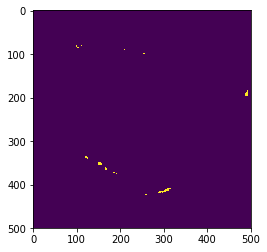

In [43]:
plt.imshow(data_cutout_binarized[:,:,50])

In [ ]:
data_cutout_binarized.dtype

## Binary opening (erosion followed by dilation)
To further denoise the volume

In [83]:
data_cutout_binarized = binary_opening(data_cutout_binarized, np.ones((3,3,3), dtype='uint16'))

## Assign voxel weights
Extracted weights are an average of normalized intensity, normalized distance from boundary, and normalized laplacian

In [84]:
ttt = vertices(data_cutout_binarized , data_cutout_raw)
vw = ttt.compute_vertex_wight()

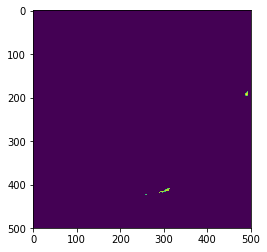

In [46]:
plt.imshow(vw[:,:,50])

## Visualize (animated)
Visualize as an animation iterating through z slices

In [ ]:
# Visualize the output (animation)

from matplotlib import animation
from IPython.display import HTML

z_rng = [0 , data_cutout_raw.shape[2]]
# z_rng = [70,80]
fig, (im1, im2) = plt.subplots(1, 2)

# fig.set_facecolor('black')
ax1 = im1.imshow(data_cutout_raw[:,:,0], animated=True)
ax2 = im2.imshow(vw[:,:,0], animated=True)

im1.get_xaxis().set_visible(False)
im2.get_xaxis().set_visible(False)

im1.get_yaxis().set_visible(False)
im2.get_yaxis().set_visible(False)

im1.set_title('Raw data')
im2.set_title('Weights')

def animate(i):
    ax1.set_data(data_cutout_raw[:,:,i])
    im1.set_title('Raw data; Z= ' + str(i))
#     ax1.set_cmap('gray')
    ax1.autoscale()
    
    ax2.set_data(vw[:,:,i])
    im2.set_title('Weights; Z=' + str(i))
#     ax2.set_cmap('gray')
    ax2.autoscale()
    return ax1

anim = animation.FuncAnimation(fig, animate, frames = np.arange(z_rng[0],z_rng[1]), interval = 50)
HTML(anim.to_jshtml())


## Skeletonize and extract connected components
Each connencted component is labeled with a unique colormap.
Outout - concomp_col: Color labeled volume (4d matrix, 4th dimesion is voxels' RGB color code)

In [85]:
skeleton = skeletonize_3d(data_cutout_binarized)

concomp = label(np.copy(skeleton) , connectivity=3)
# skeleton = binary_closing(skeleton, np.ones((5,5,5), dtype='uint8'))
# skeleton = binary_opening(skeleton, np.ones((3,3,3), dtype='uint8'))
cmap = plt.cm.get_cmap('nipy_spectral' , np.unique(concomp).size)

concomp_col = np.empty(concomp.shape + (3,), dtype = 'uint8')
for col in np.arange(np.unique(concomp).size):
    tmp = cmap(col)[0:-1]
    tmp = tuple(i*255 for i in tmp)
    concomp_col[concomp == col] = tmp

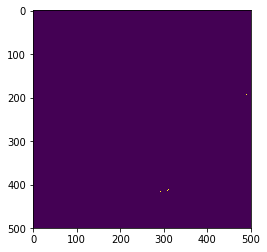

In [71]:
plt.imshow(skeleton[:,:,50])

In [ ]:
skeleton.shape

## Ingest to Boss
Upload the results back to Boss

In [ ]:
# Helper functions for ingestation (C: vikram)
def get_channel_resource(rmt, chan_name, coll_name, exp_name, type='image', base_resolution=0, sources=[], datatype='uint16', new_channel=True):
    channel_resource = ChannelResource(chan_name, coll_name, exp_name, type=type, 
                                    base_resolution=base_resolution, sources=sources, datatype=datatype)
    if new_channel: 

        new_rsc = rmt.create_project(channel_resource)
        return new_rsc

    return channel_resource



def upload_to_boss(rmt, data, channel_resource, resolution=0):
    Z_LOC = 0
    size = data.shape
    for i in range(0, data.shape[Z_LOC], 16):
        last_z = i+16
        if last_z > data.shape[Z_LOC]:
            last_z = data.shape[Z_LOC]
        print(resolution, [0, size[2]], [0, size[1]], [i, last_z])
        rmt.create_cutout(channel_resource, resolution, [0, size[2]], [0, size[1]], [i, last_z], np.asarray(data[i:last_z,:,:], order='C'))
        
        
# Ingest the results back to Boss
rmt = BossRemote()
new_coll_name = 'tractography'
new_exp_name = 'mvpsprint3'
new_chan_name = 'annot_4'
create_new_channel = False

if create_new_channel:
    # new channel
    new_chan_resource = get_channel_resource(rmt, new_chan_name, new_coll_name, new_exp_name , new_channel=True)
    upload_to_boss(rmt, concomp, new_chan_resource)
    
else:
    # get existing channel
    chan_resource = rmt.get_channel(chan_name= new_chan_name, coll_name=new_coll_name, exp_name=new_exp_name)
    upload_to_boss(rmt, concomp, chan_resource)


## Or, save to disk as tiff files

In [ ]:
imsave('./test.tiff' , img_as_ubyte(skeleton))


In [ ]:
# imsave('./output_data/test_tractography/test_'+test_lbl+'_binarized.tiff' , img_as_ubyte(data_cutout_binarized)*255)
imsave('/output_data/test_tractography/test_'+test_lbl+'_skeleton.tiff' , skeleton)
# imsave('./output_data/test_tractography/test_'+test_lbl+'_con_comp.tiff' , concomp_col)
# imsave('./output_data/test_tractography/test_'+test_lbl+'_raw_2.tiff' , img_as_ubyte(data_cutout_raw))

## Quantification
For each machine labeled voxel find the closest manually labeled voxel (in physical units)

In [86]:
labeled_0_nz_voxel_ids = np.genfromtxt('../../annotation_csv/tractography/tractography_'+test_lbl+'.swc' , delimiter=' ')
labeled_0_nz_voxel_ids = np.around(np.uint16(labeled_0_nz_voxel_ids[:,2:5]))
labeled_0_nz_voxel_ids = labeled_0_nz_voxel_ids[:, [1,0,2]]
nz_skeleton = np.asarray(np.nonzero(skeleton)).T

In [87]:
labeled_tiff = np.zeros(skeleton.shape , dtype='uint8')


In [88]:
labeled_tiff = np.zeros(skeleton.shape , dtype='uint8')
for row in labeled_0_nz_voxel_ids:
    labeled_tiff[row[0] , row[1] , row[2]] = 255

In [89]:
# imsave('./output_data/test_tractography/test_'+test_lbl+'_labeled.tiff' , img_as_ubyte(labeled_tiff))

In [90]:
def find_closest_voxel(voxel, vol_idx):
    '''
    vol_idx: indices of nonzero elements; shape: (nx3)
    Finds the closest non-zero voxel in vol_idx to point x,y,z
    '''
    subtrc = vol_idx - [voxel[0], voxel[1], voxel[2]]
    minIdx = np.argmin(np.linalg.norm(subtrc, axis = 1))
       
    return vol_idx[minIdx,:]

def quantify1(nz_data_1, nz_data_2):
    '''
    Method 1 of quantification: for each voxel in nz_data_1, find the closest voxel in the nz_data_2
    '''
    # find indices of non-zero elements in test data:
    closest_voxels = np.empty(nz_data_1.shape)
    for idx, voxel in enumerate(nz_data_1):
        closest_voxel = find_closest_voxel(voxel , nz_data_2)
        closest_voxels[idx,:] = closest_voxel
        
    return closest_voxels
        
        

Convert to physical units:

(2580, 3)


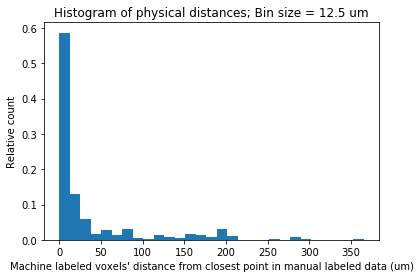

In [91]:
# physical sizes:
x_size = 0.585 #um
y_size = 0.585 #um
z_size = 5.0 #um
method = 'm2l' #m2l (for each machine labled find the closest manual labels) or 
               #l2m (for each manual labeled find the closest machine labeled)

nz_test_data = np.asarray(np.nonzero(skeleton)).T
if method == 'm2l':
    closest_voxels = quantify1(nz_skeleton, labeled_0_nz_voxel_ids)
    subtrct = closest_voxels - nz_skeleton
elif method == 'l2m':
    closest_voxels = quantify1(labeled_0_nz_voxel_ids, nz_skeleton)
    subtrct = closest_voxels - labeled_0_nz_voxel_ids
    
distances = np.linalg.norm(subtrct.dot(np.diag([x_size, y_size, z_size])), axis = 1)
binSize = 12.5 #um
nbins = np.uint32(np.around((np.max(distances) - np.min(distances))/12.5))

histret=plt.hist(distances, bins=nbins, weights=np.zeros_like(distances) + 1. / distances.size )
plt.xlabel((
    'Machine labeled' if method == 'm2l' else 'Manual labled' ) + ' voxels\' distance from closest point in ' + (
    'manual labeled data (um)' if method == 'm2l' else 'machine labeled data (um)'))
plt.ylabel('Relative count')
plt.title('Histogram of physical distances; Bin size = ' + str(binSize) + ' um')
print(closest_voxels.shape)


## Overlay volumes for visualization

In [79]:

cmap = plt.cm.get_cmap('nipy_spectral' , np.unique(concomp).size)
overlaid = color.gray2rgb(img_as_ubyte(data_cutout_raw))
overlaid[skeleton != 0] = np.asarray([255,0,0], dtype='uint8')

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [80]:
for row in labeled_0_nz_voxel_ids:
    if np.array_equal(overlaid[row[0] , row[1] , row[2],:] , np.asarray([255,0,0], dtype='uint8')):
        overlaid[row[0] , row[1] , row[2],:] = np.asarray([255,255,0], dtype='uint8')
    else:
        overlaid[row[0] , row[1] , row[2],:] = np.asarray([0,255,0], dtype='uint8')
                                                          

Save the overlaind volume as tiff:

In [81]:
imsave('./output_data/test_tractography/test_'+test_lbl+'_overlaid_80th_sub-to-10k.tiff' , overlaid)

In [ ]:
# from scipy.spatial import Delaunay
# T0 = Delaunay()

In [92]:
# for saving in swc format:

unique_vals = np.unique(concomp)

clust_ids = np.empty((unique_vals.shape[0]-1))
outputmat = np.empty(((0,3)))
for i,cluster in enumerate(unique_vals[1:]):
        curr_clust = np.asarray(np.where( concomp == cluster )).T
        clust_ids[i] = curr_clust.shape[0]
        outputmat = np.append(outputmat , curr_clust, axis=0)


clust_ids = np.append([0] , np.cumsum(clust_ids)[:-1])

first_col = np.arange(1, outputmat.shape[0]+1).reshape(outputmat.shape[0],1)
second_col = 3*np.ones((outputmat.shape[0],1))
outputmat = np.append(second_col,outputmat, axis=1)
outputmat = np.append(first_col,outputmat, axis=1)

second_to_last_col = np.ones((outputmat.shape[0],1))
outputmat = np.append(outputmat, second_to_last_col, axis=1)
last_col = np.arange(outputmat.shape[0]).reshape(outputmat.shape[0],1)
last_col[np.uint16(clust_ids)] = -1
outputmat = np.append(outputmat, last_col ,axis=1)

np.savetxt('./output_data/test_tractography/CSV_outputs/test_4_output_nosubs.swc' , outputmat, fmt='%i')

In [94]:
skeleton.shape

(500, 500, 100)